In [1]:
import tarfile
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench import load_results

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

import copy

In [2]:
results = load_results("results/dike_model_test_sobol_do_nothing.tar.gz")
#results = load_results("results/dike_model_test_sobol_4_policies.tar.gz")
#results = load_results("results/dike_model_test_sobol_policies_example_policies.tar.gz")
experiments, outcomes = results

In [3]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())
experiments.head()


dict_keys(['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,3,192.050838,10.0,0.357547,168.258603,10.0,0.770128,211.658902,1.0,0.957072,...,0,0,0,0,0,0,0,0,policy 0,dikesnet
1,126,192.050838,10.0,0.357547,168.258603,10.0,0.770128,211.658902,1.0,0.957072,...,0,0,0,0,0,0,0,1,policy 0,dikesnet
2,3,98.197546,10.0,0.357547,168.258603,10.0,0.770128,211.658902,1.0,0.957072,...,0,0,0,0,0,0,0,2,policy 0,dikesnet
3,3,192.050838,1.0,0.357547,168.258603,10.0,0.770128,211.658902,1.0,0.957072,...,0,0,0,0,0,0,0,3,policy 0,dikesnet
4,3,192.050838,10.0,0.927474,168.258603,10.0,0.770128,211.658902,1.0,0.957072,...,0,0,0,0,0,0,0,4,policy 0,dikesnet


In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(5)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)


In [5]:
kpi_list=list(outcomes.keys())
ooi=kpi_list[5]
print(kpi_list)
print(ooi)

['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
A.2_Expected Number of Deaths


## Grouping outcomes per dike ring

In [6]:
from collections import defaultdict
group = defaultdict(list)
tmp_key=kpi_list[0].split(sep='_')[0]
print(tmp_key)
for i in kpi_list:
    tmp=i.split(sep='_')[0]
    if tmp == tmp_key:
        group[tmp_key].append(i)
    else:
        tmp_key=tmp
        group[tmp_key].append(i)
        
    
    

A.1


In [7]:
dikerings=group.keys()
print(dikerings)

dict_keys(['A.1', 'A.2', 'A.3', 'A.4', 'A.5', 'RfR Total Costs', 'Expected Evacuation Costs'])


In [8]:
def analyze(results, kpi,planning_step):
    """analyze results using SALib sobol, returns a dataframe"""
    _, outcomes = results
    
    problem = get_SALib_problem(dike_model.uncertainties)
    y = outcomes[kpi][:,planning_step]
    sobol_indices = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
    sobol_stats = {key: sobol_indices[key] for key in ["ST", "ST_conf", "S1", "S1_conf"]}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem["names"])
    sobol_stats.sort_values(by="ST", ascending=False)
    s2 = pd.DataFrame(sobol_indices["S2"], index=problem["names"], columns=problem["names"])
    s2_conf = pd.DataFrame(sobol_indices["S2_conf"], index=problem["names"], columns=problem["names"])
    return sobol_stats, s2, s2_conf

In [9]:
outcomes['A.1_Dike Investment Costs'].nonzero()[0].size

0

In [10]:
dikerings

dict_keys(['A.1', 'A.2', 'A.3', 'A.4', 'A.5', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [11]:
sobol_data=defaultdict(dict)
s2_data= defaultdict(dict)
s2_data_conf=defaultdict(dict)

for k,v in group.items():
    sobol_data[k]=defaultdict(dict)
    s2_data[k]=defaultdict(dict)
    s2_data_conf[k]=defaultdict(dict)
    for ooi in v:
        sobol_data[k][ooi]=defaultdict(pd.DataFrame)
        s2_data[k][ooi]=defaultdict(dict)
        s2_data_conf[k][ooi]=defaultdict(dict)              
        for planning_step in range(0,3):
            if outcomes[ooi].nonzero()[0].size:
                sobol_stats, s2, s2_conf = analyze(results, ooi, planning_step)
                sobol_data[k][ooi][planning_step] = sobol_stats
                s2_data[k][ooi][planning_step] = s2
                s2_data_conf[k][ooi][planning_step]=s2_conf
            else: 
                del sobol_data[k][ooi]
                break

            
    

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [12]:
#sobol_data['A.2'].keys()

In [13]:
#planning_step = 0
#sobol_stats, s2, s2_conf = analyze(results, ooi, planning_step)

In [14]:
#indices=sobol_data['A.1']['A.1_Expected Annual Damage'][0][['S1','ST']]
#err=sobol_data['A.1']['A.1_Expected Annual Damage'][0][['S1_conf','ST_conf']]
#indices.plot.bar(yerr=err.values.T)

In [15]:
#dike= 'A.1'
#sobol_data[step][dike].keys()


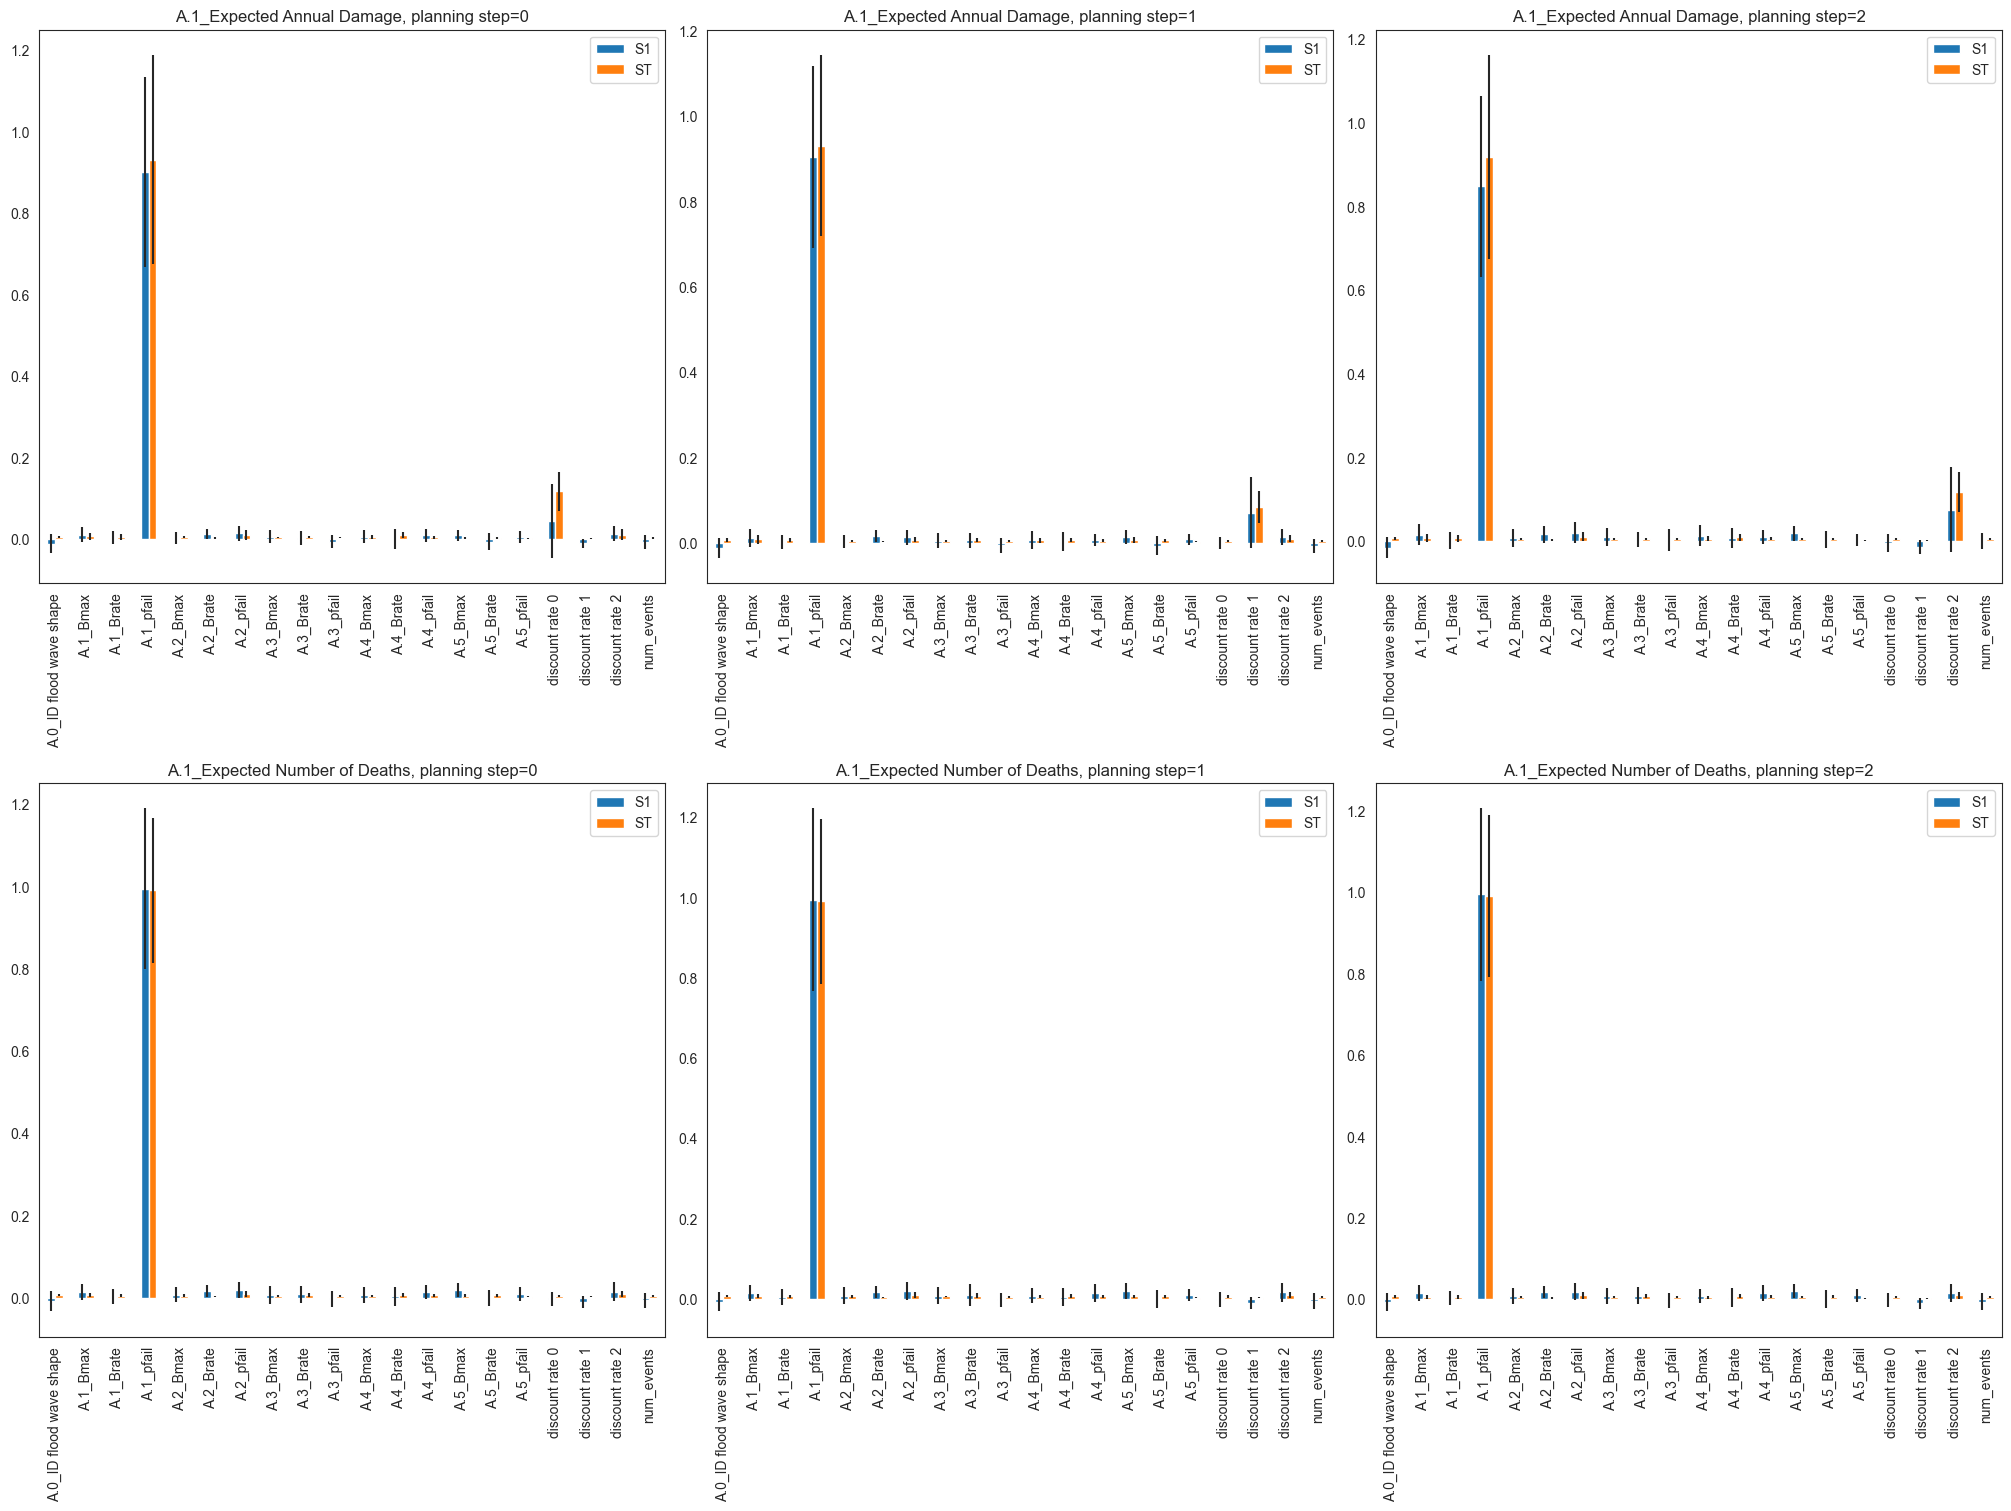

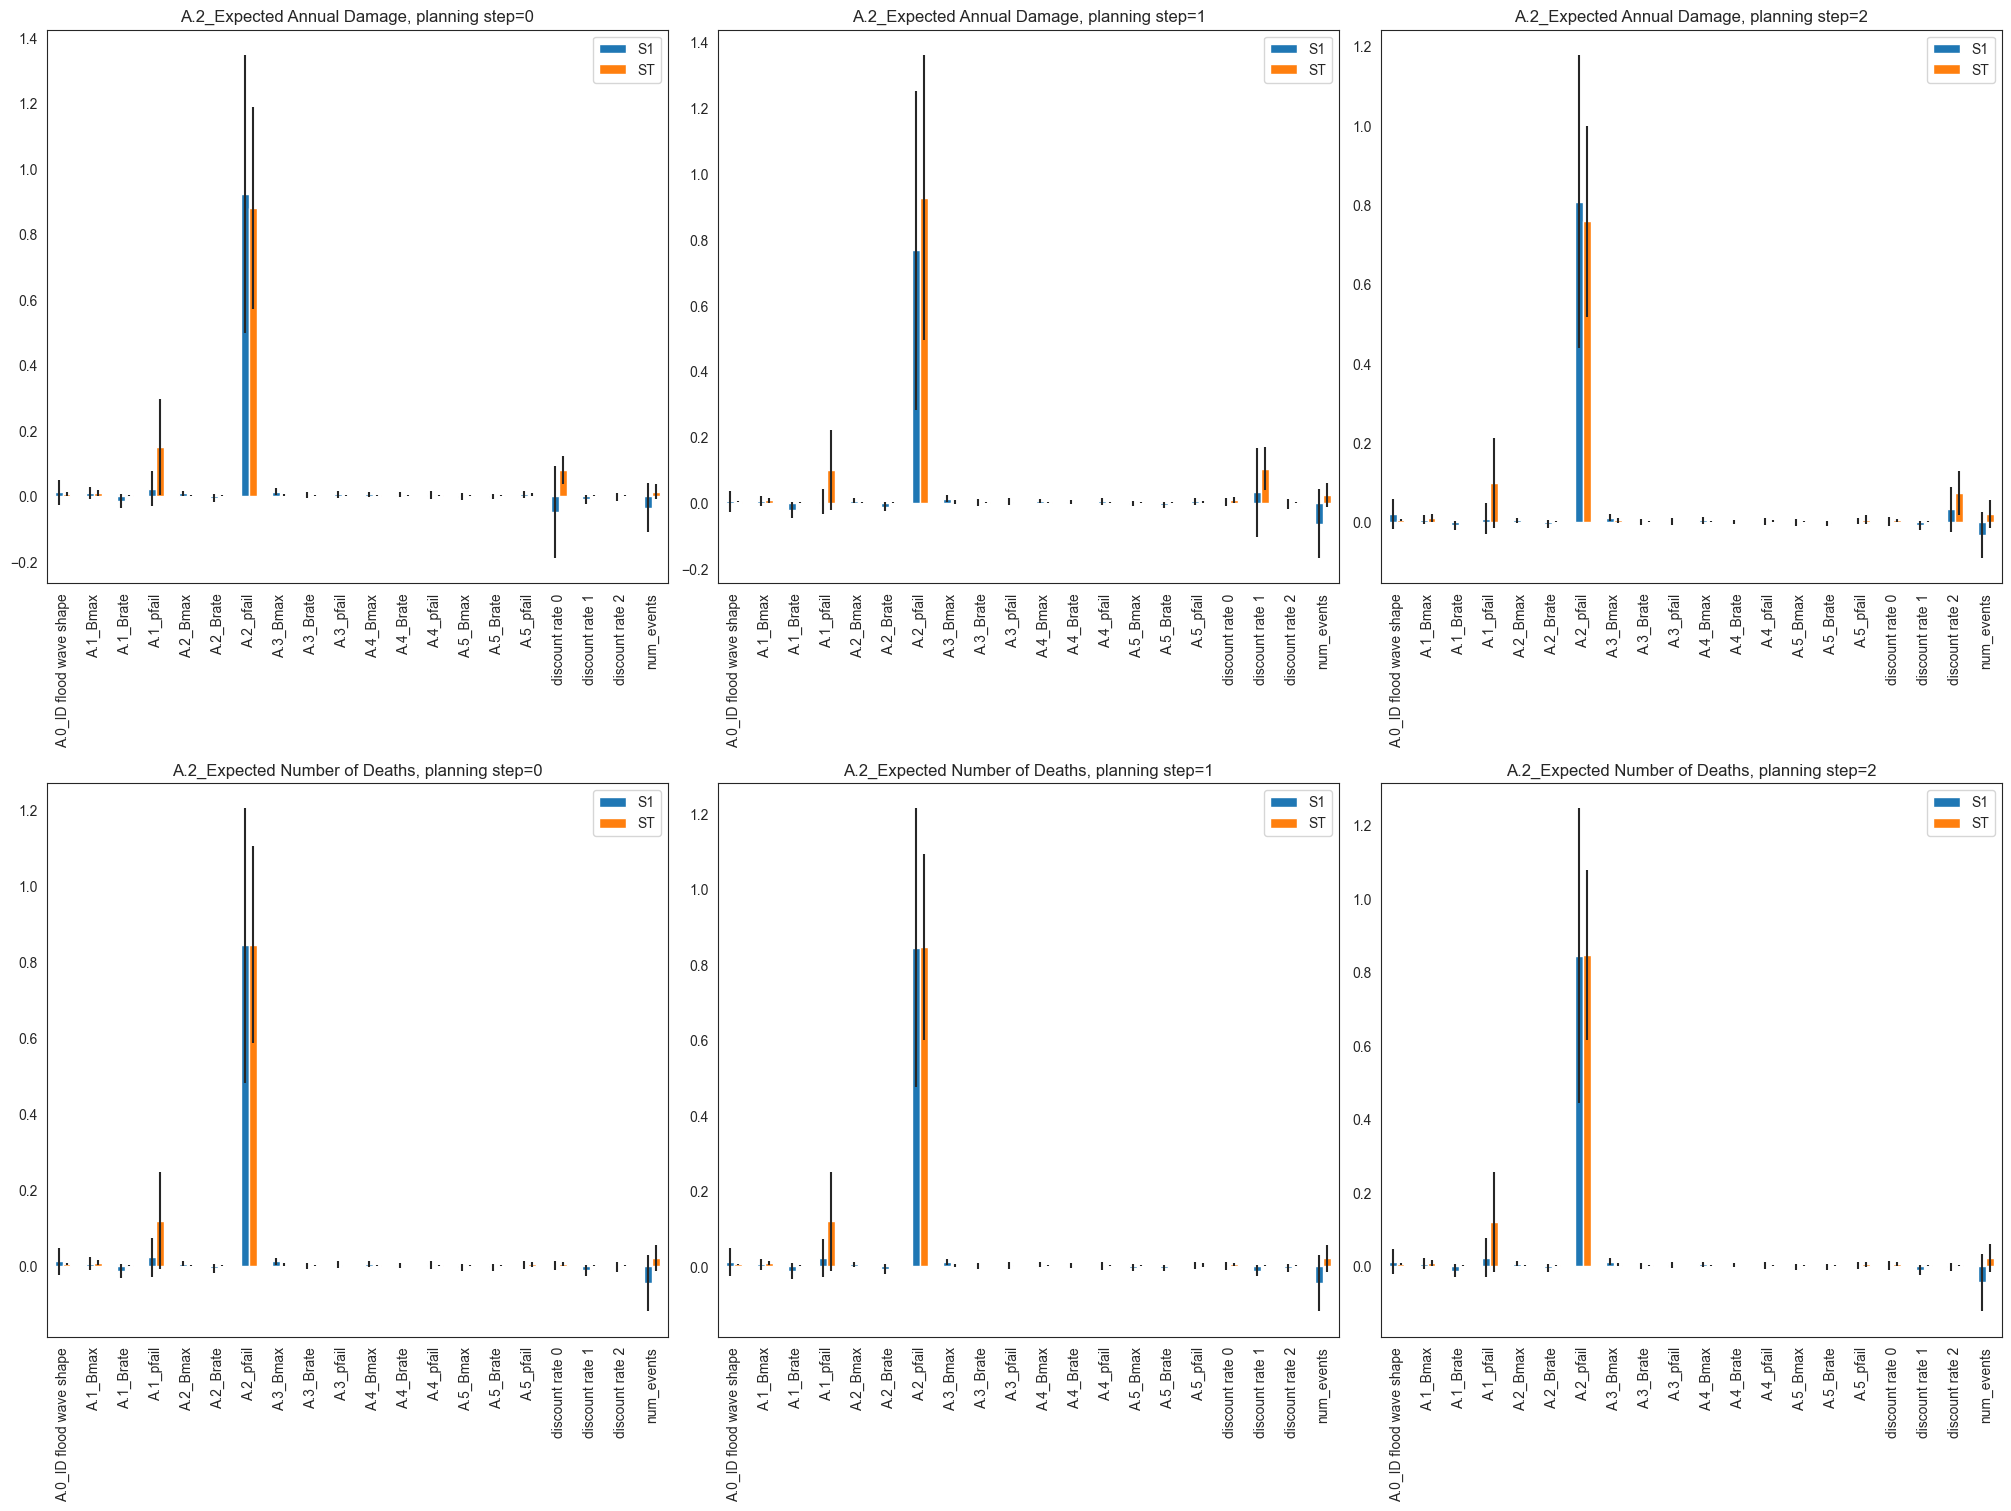

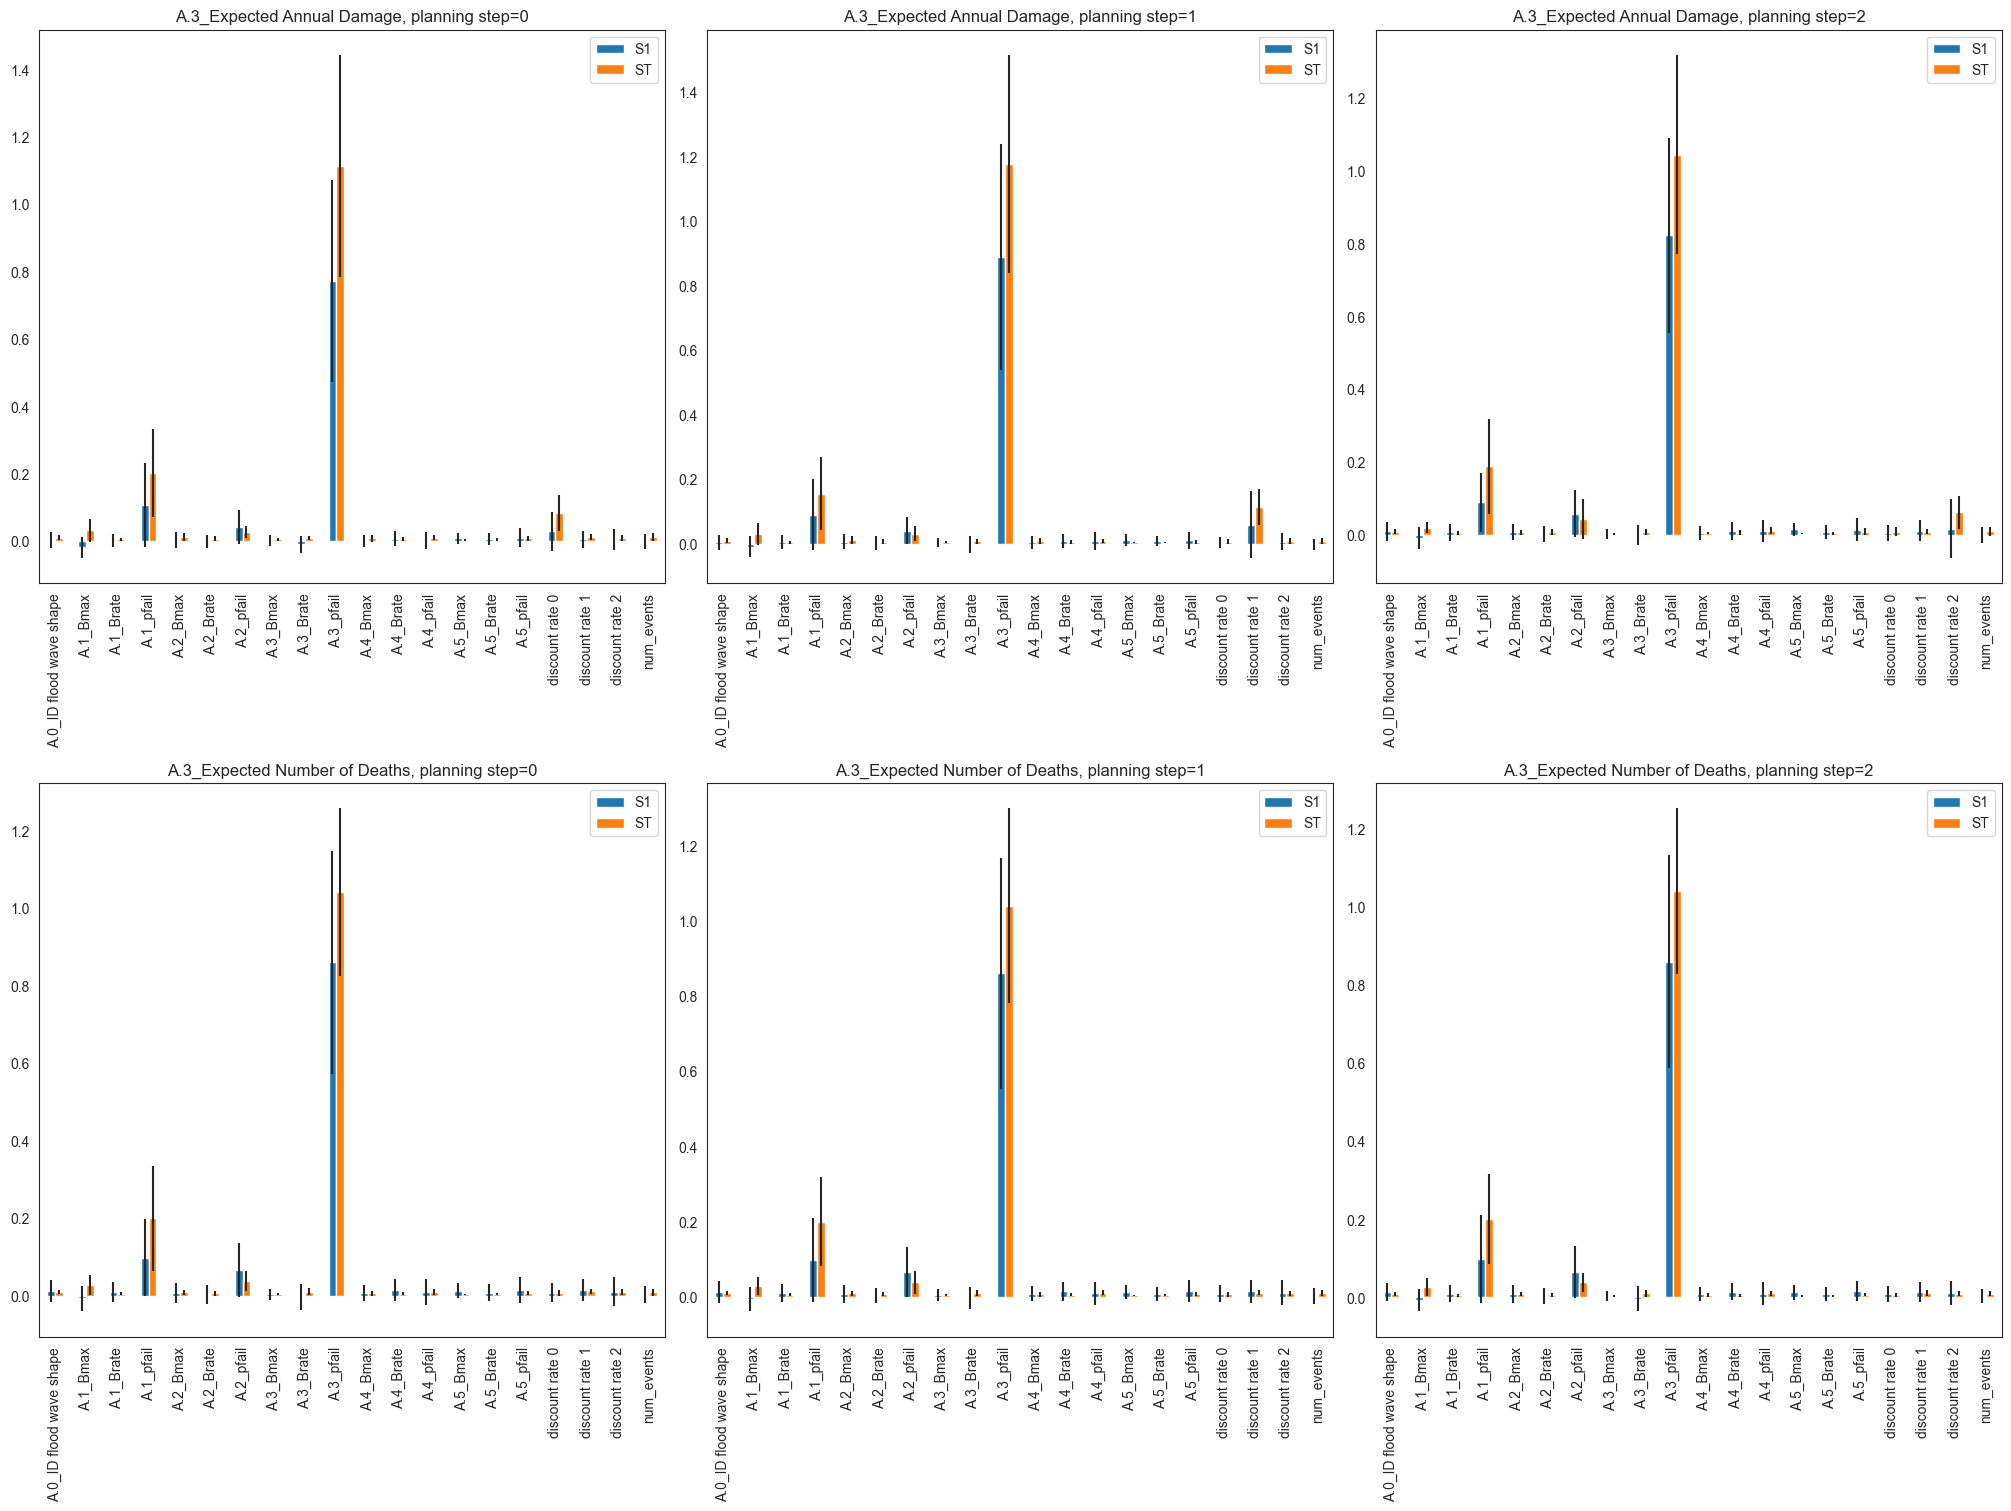

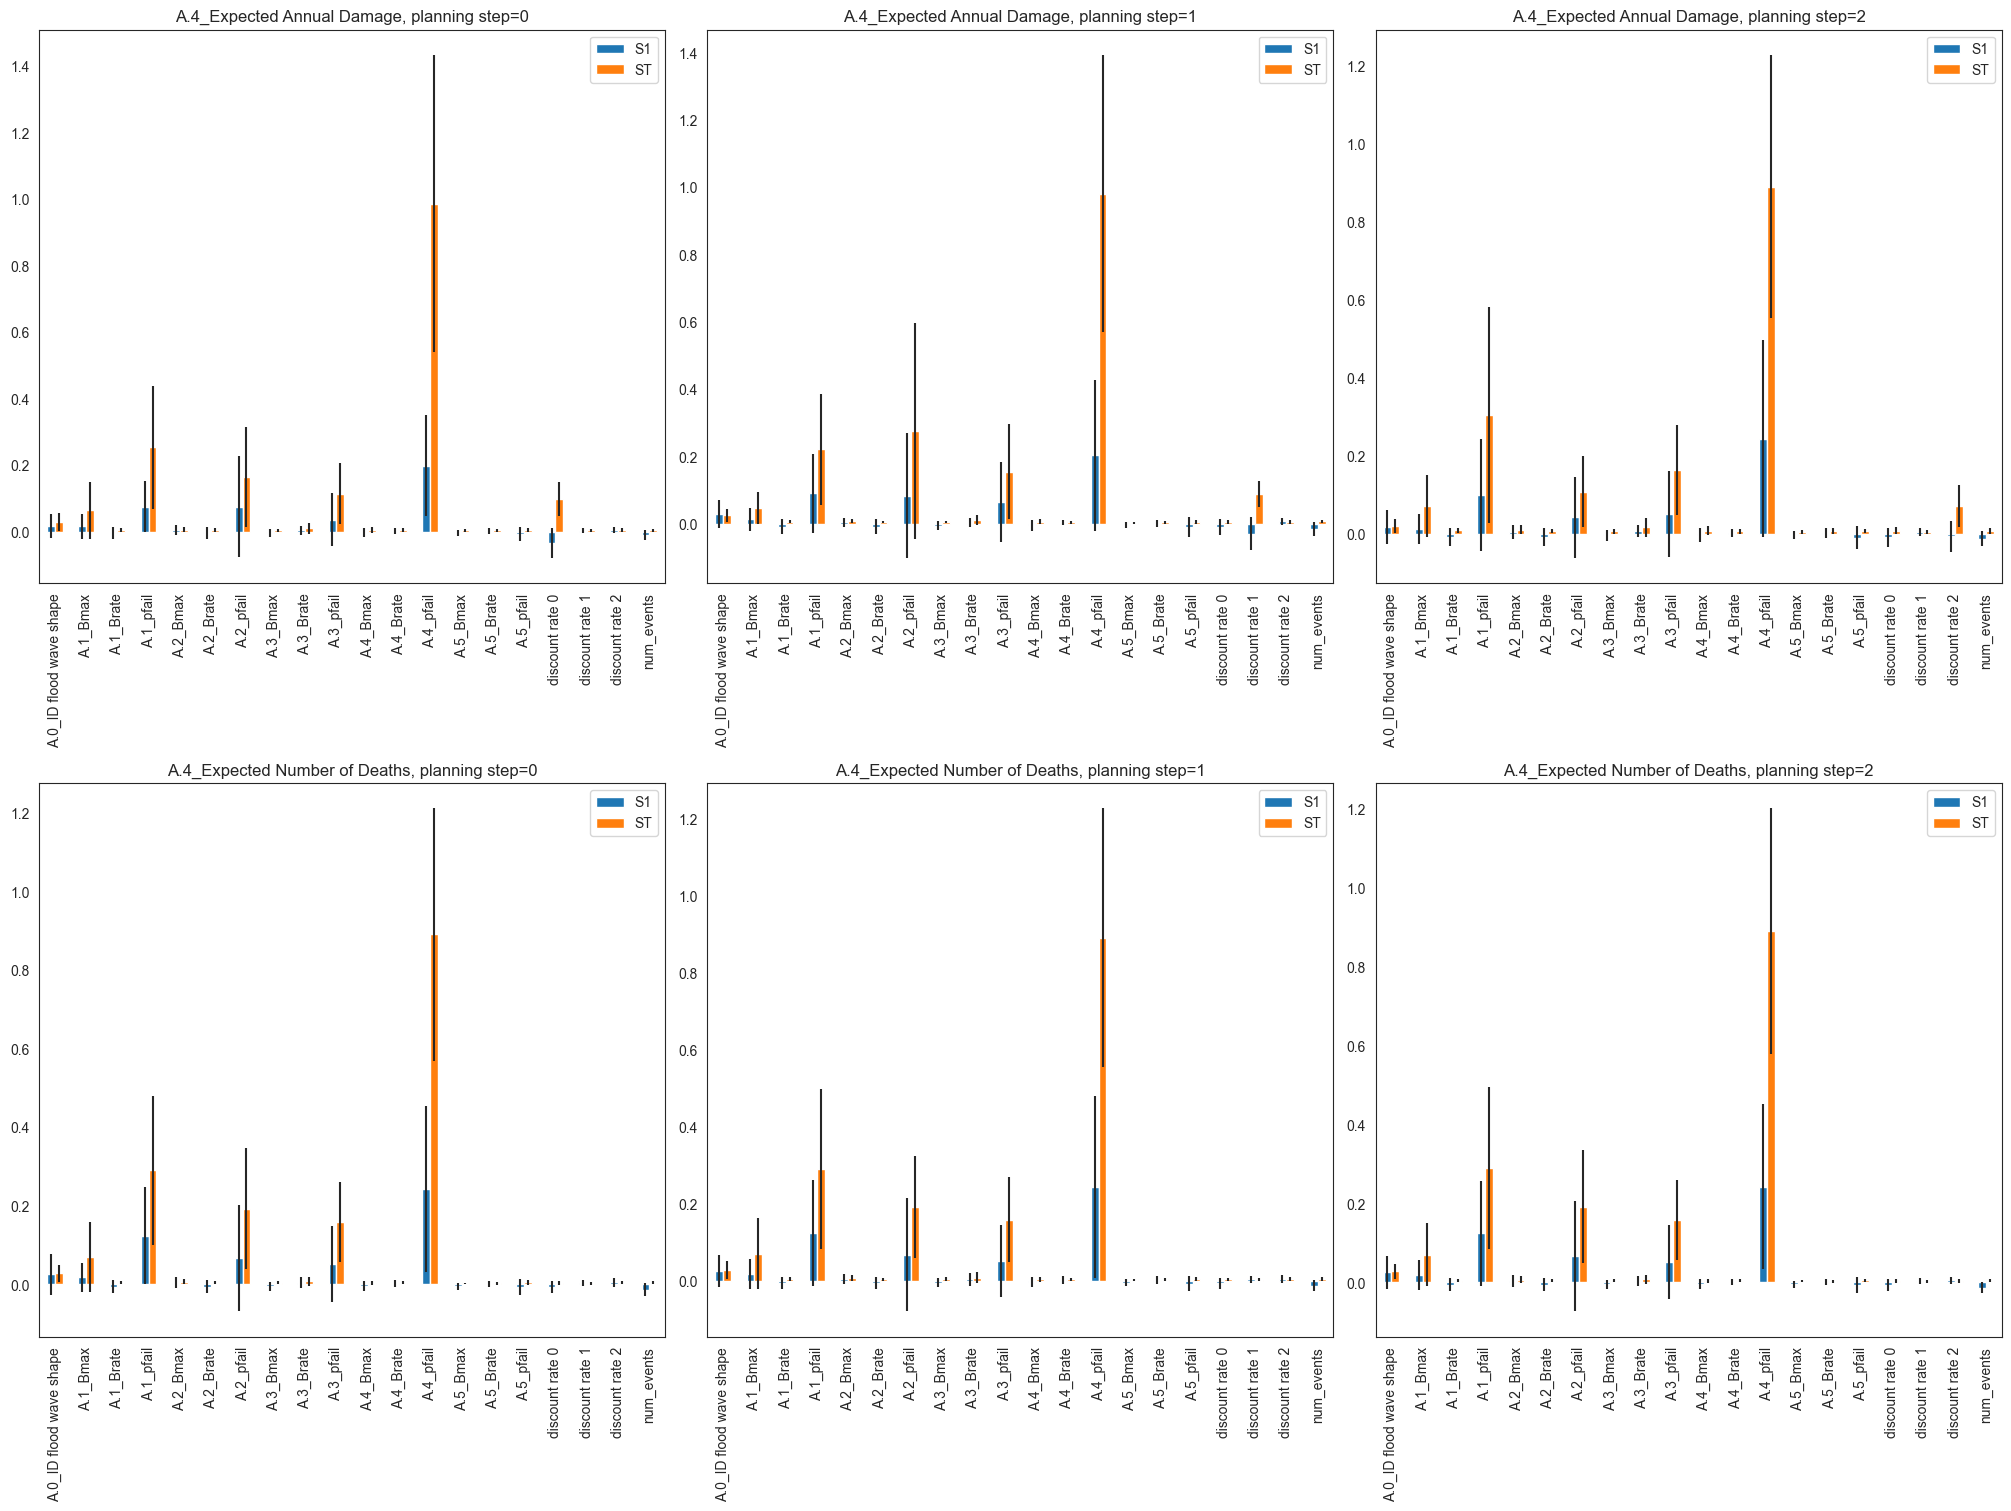

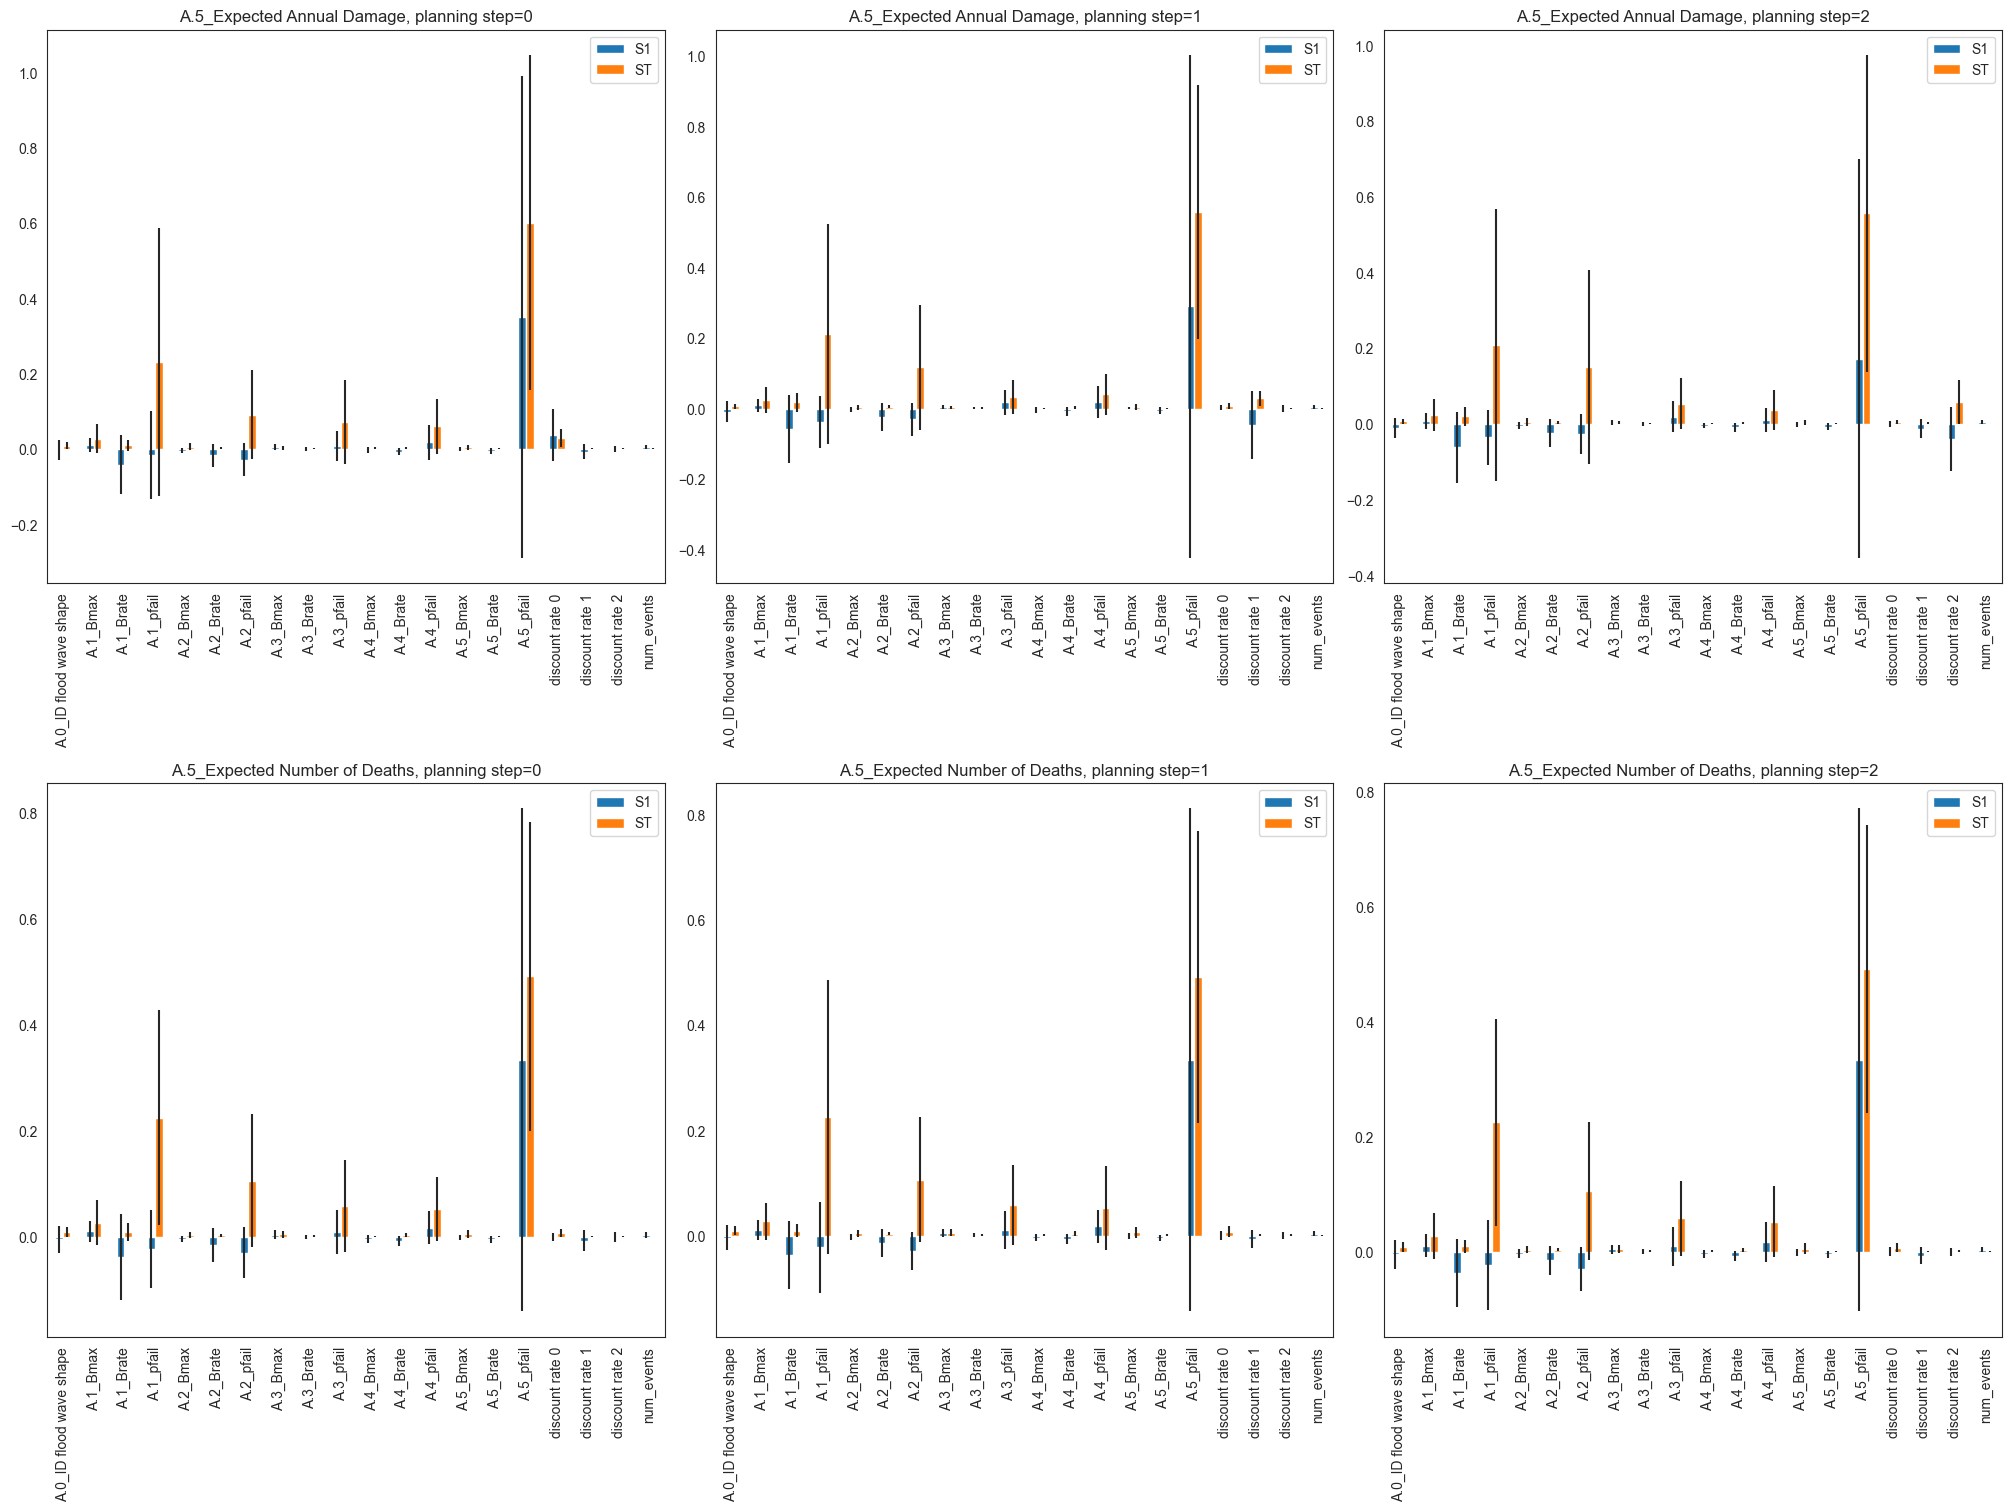

In [17]:
#fig, axes =plt.subplots(3,1,figsize=(8,10),constrained_layout=True)
#fig.tight_layout()
#i=0
#step=0
#dike='A.1'
#ooi='A.1_Expected Annual Damage'

sns.set_style('white')
for dike, info in sobol_data.items():
    num_ooi = len(info.keys())
    if (num_ooi):
        num_steps=3
        fig, axes =plt.subplots(num_ooi,num_steps,figsize=(20,15),constrained_layout=True)
        #axes.flatten()
        i=0
        for ooi,planning_step in info.items():
        #num_steps=len(planning_step.keys())
            for step,df in planning_step.items():
                indices = df[['S1','ST']]
                err =  df[['S1_conf','ST_conf']]
                indices.plot.bar(yerr=err.values.T,ax=axes[i][step],title=f"{ooi}, planning step={step}")
            i+=1
        fig.savefig(f"sobol_plots/planning_step={step}, category={dike}.png")
        del fig

In [ ]:
exp,_=results

In [ ]:
problem=get_SALib_problem(dike_model.uncertainties)

In [ ]:
#Y = results
Y = outcomes[ooi][:,planning_step]
exp,_=results
n_exp = exp.shape[0]

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

In [ ]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
ax.legend(loc=(1.01,0))
plt.show()

### Analysing the Importance of different uncertainties under different policies

In [ ]:
experiments.policy.unique()

In [ ]:
sobol_results = {}
problem = get_SALib_problem(dike_model.uncertainties)
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = outcomes[ooi][:,planning_step][logical]
    indices = sobol.analyze(problem, y)
    sobol_results[policy] = indices

In [ ]:
axes[1]

In [ ]:
fig, axes = plt.subplots(3,3)
fig.set_size_inches(24, 16)
axes.flatten()

i=0
for policy in experiments.policy.unique():
    sobol_results[policy].plot(ax = axes[i])
    #plt.title(f"{policy}")
    i+=1

In [ ]:
sobol_results['policy 1'].plot()